# SIAMESE NETWORKS

# Import and required packages

For this lesson you will need some popular packages such as numpy and pandas in addition to PyTorch and torchtext. The latter can be installed via:

`> pip install torchtext`

In [1]:
import copy
import os

import numpy as np
import pandas as pd

# PyTorch imports.
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchtext import data
from torchtext.vocab import GloVe
import torch.nn.functional as F

# Required for displaying plots from pandas dataframes.
%matplotlib inline
import matplotlib.pyplot as plt

# Required for displaying images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML 

# Setting seeds for reproducibility.
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Configuration

In [2]:
batch_size = 32
embedding_dim = 300
hidden_size = 100
gpu = 0
learning_rate = 0.001
max_sent_len = 50
print_freq = 1000
num_epochs = 3

# The PyTorch and torchtext dataset API

We will process the datasets using a standard dataset API which will provide us with an uniform input format for our data. It is recommended to directly look at the code and docstrings for understanding the dataset API: [https://github.com/pytorch/text/tree/master/torchtext/data](https://github.com/pytorch/text/tree/master/torchtext/data)

In [3]:
class Quora():
    def __init__(self, batch_size, embedding_dim, gpu):
        self.RAW = data.RawField()
        self.TEXT = data.Field(batch_first=True,
                               lower=True,
                               fix_length=max_sent_len)
        self.LABEL = data.Field(sequential=False,
                                unk_token=None)

        self.train, self.dev, self.test = data.TabularDataset.splits(
            path='./quora',
            train='train.tsv',
            validation='dev.tsv',
            test='test.tsv',
            format='tsv',
            fields=[('label', self.LABEL),
                    ('q1', self.TEXT),
                    ('q2', self.TEXT),
                    ('id', self.RAW)])

        self.TEXT.build_vocab(self.train, self.dev, self.test, 
                              vectors=GloVe(name='6B', dim=embedding_dim),
                              unk_init=torch.zeros((1, embedding_dim)).uniform_(-0.25, 0.25))
        
        self.LABEL.build_vocab(self.train)

        self.train_iter, self.dev_iter, self.test_iter = \
            data.Iterator.splits((self.train, self.dev, self.test),
                                 device=gpu,
                                 batch_sizes=[batch_size] * 3,
                                 shuffle=True)

        self.max_word_len = max([len(w) for w in self.TEXT.vocab.itos])

# Instantiating the dataset

In [4]:
dataset = Quora(batch_size, embedding_dim, gpu)
word_vocab_size = len(dataset.TEXT.vocab)
unk_id = dataset.TEXT.vocab.stoi['<unk>']
pad_id = dataset.TEXT.vocab.stoi['<pad>']

print('[INFO] Vocabulary size: {}'.format(word_vocab_size))
print('[INFO] <unk> id: {}'.format(unk_id))
print('[INFO] <pad> id: {}'.format(pad_id))

[INFO] Vocabulary size: 107161
[INFO] <unk> id: 0
[INFO] <pad> id: 1


# Siamese network

The following image is from [Learning a Similarity Metric Discriminatively, with Application to Face Verification](http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf) and it depicts a siamese network.

<img src="figures/siamese-lecun.png" alt="Siamese Network" style="width: 800px;"/>

The key characteristics of such a network are:
* the input is constituted by a pair of objects
* each input is encoded independently by the same module (parameters are shared between branches)
* an energy function computes the distance or similarity between the encoded representations
* a contrastive loss is used to optimize the network

## Contrastive loss

We select the cosine loss between sentence embeddings as our contrastive loss.

PyTorch already contains an implementation of such loss, called [CosineEmbeddingLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CosineEmbeddingLoss):

<img src="figures/cosine-loss.png" alt="Cosine Embedding Loss" style="width: 600px;"/>



In [5]:
dummy_vector_a = torch.autograd.Variable(torch.FloatTensor([[1., 2.]]))
dummy_vector_b = torch.autograd.Variable(torch.FloatTensor([[1., 2.]]))

dummy_label = torch.autograd.Variable(torch.FloatTensor([[-1]]))

print(F.cosine_similarity(dummy_vector_a, dummy_vector_b))

print(torch.nn.CosineEmbeddingLoss(margin=0.4)(dummy_vector_a, dummy_vector_b, dummy_label))

Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
 0.6000
[torch.FloatTensor of size 1]



## Plotting the loss: y == 1

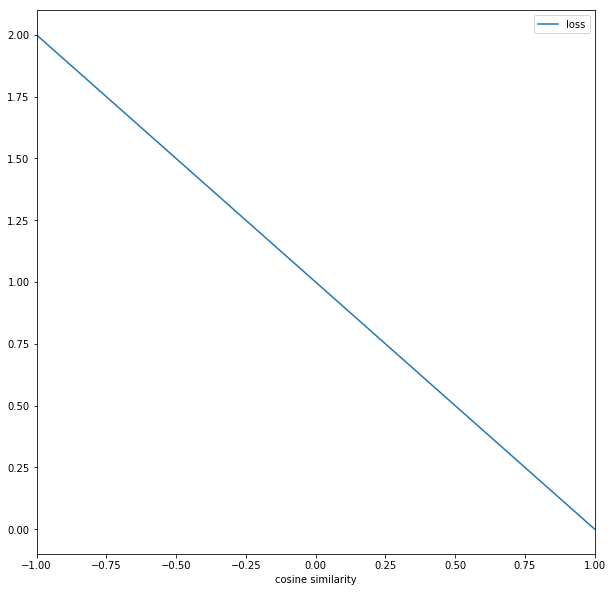

In [6]:
sims, losses = [], []
for sim in [0.01 * x for x in range(-100, 101)]:
    sims.append(sim)
    losses.append(1 - sim)
    
loss_df = pd.DataFrame()
loss_df["cosine similarity"] = sims
loss_df["loss"] = losses
loss_df.plot(x="cosine similarity", y="loss", figsize=(10,10))

## Plotting the loss: y == -1

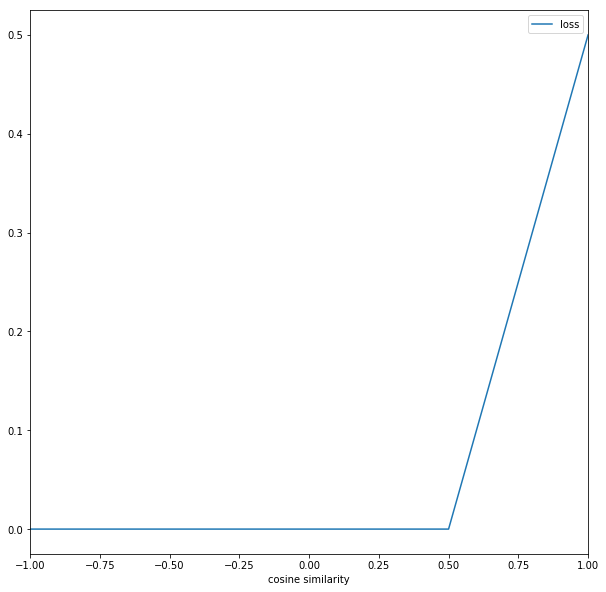

In [7]:
margin = 0.5
sims, losses = [], []
for sim in [0.01 * x for x in range(-100, 101)]:
    sims.append(sim)
    losses.append(max(0, sim - margin))
    
loss_df = pd.DataFrame()
loss_df["cosine similarity"] = sims
loss_df["loss"] = losses
loss_df.plot(x="cosine similarity", y="loss", figsize=(10,10))

# Siamese network implementation

In [8]:
class SiameseNetwork(nn.Module):  
    def __init__(self,
                 embedding_dim,
                 word_vocab_size,
                 hidden_size,
                 data):
        super(SiameseNetwork, self).__init__()
        
        self.hidden_size = hidden_size

        self.word_emb = nn.Embedding(word_vocab_size, embedding_dim)
        self.word_emb.weight.data.copy_(data.TEXT.vocab.vectors)
        self.word_emb.weight.requires_grad = False
        
        self.conv_1 = nn.Conv1d(kernel_size=1, in_channels=embedding_dim, out_channels=self.hidden_size)
        self.conv_2 = nn.Conv1d(kernel_size=3, in_channels=embedding_dim, out_channels=self.hidden_size)
        self.conv_3 = nn.Conv1d(kernel_size=5, in_channels=embedding_dim, out_channels=self.hidden_size)
        self.convs = [self.conv_1, self.conv_2, self.conv_3]
        
        self.criterion = torch.nn.CosineEmbeddingLoss(margin=0.8)
        
    def encode(self, question):
        emb = self.word_emb(question)
        emb_for_conv = emb.transpose(1, 2)
        
        pooled_outputs = []
        for conv_layer in self.convs:
            conv = conv_layer(emb_for_conv)
            pooled_output = F.relu(F.max_pool1d(conv, conv.size(2))).squeeze(2)
            pooled_outputs.append(pooled_output)
            
        return torch.cat(tuple(pooled_outputs), dim=1)

    def forward(self, q1, q2):
        encoded_q1 = self.encode(q1)
        encoded_q2 = self.encode(q2)
        return encoded_q1, encoded_q2
    
    def compute_batch_stats(self, model_output, batch):
        """Returns output, batch loss and number of correct predictions."""
        encoded_q1, encoded_q2 = model_output
        
        # Labels must are mapped from 0/1 to -1/1.
        batch_loss = self.criterion(encoded_q1, encoded_q2, batch.label.float() * 2.0 - 1.0 )
        
        similarity = F.cosine_similarity(encoded_q1, encoded_q2)
        predictions = similarity.clone()
        predictions[similarity > 0.5] = 1
        predictions[similarity <= 0.5] = 0
        correct_predictions = (predictions.squeeze() == batch.label.float()).sum().float()
        
        return similarity, batch_loss, correct_predictions      

# Multilayer Perceptron (MLP) baseline

In [9]:
class Attention(nn.Module):  
    def __init__(self,
                 context_dim,
                 hidden_dim,
                 attn_size):
        super(Attention, self).__init__()
        self.context_proj = nn.Linear(context_dim, attn_size, bias=True)
        self.hidden_proj = nn.Linear(hidden_dim, attn_size, bias=True)
        self.attn = nn.Linear(attn_size, 1, bias=True)
    
    def forward(self,
                context,  # batch x context_dim
                embedded_sequence,  # batch x sequence_length x hidden_dim
                mask=None,
               ):
        augmented_hidden_state = self.context_proj(context).unsqueeze(1) + self.hidden_proj(embedded_sequence)
        augmented_hidden_state = context.unsqueeze(1) + embedded_sequence
        attn_scores = F.tanh(self.attn(augmented_hidden_state))
        
        if mask is not None:
            attn_scores.data.masked_fill_(mask.squeeze().byte().data, -9999.9)
            
        attn_scores = F.softmax(attn_scores)
        return embedded_sequence * attn_scores

class MLP(nn.Module):  
    def __init__(self,
                 embedding_dim,
                 word_vocab_size,
                 hidden_size,
                 data,
                 use_attention=False):
        super(MLP, self).__init__()
        
        self.hidden_size = hidden_size
        self.use_attention = use_attention

        self.word_emb = nn.Embedding(word_vocab_size, embedding_dim)
        self.word_emb.weight.data.copy_(data.TEXT.vocab.vectors)
        self.word_emb.weight.requires_grad = False
        
        self.conv_1 = nn.Conv1d(kernel_size=3, in_channels=embedding_dim, out_channels=self.hidden_size, padding=1)
        self.conv_2 = nn.Conv1d(kernel_size=3, in_channels=embedding_dim, out_channels=self.hidden_size, padding=1)
        
        self.attention = Attention(self.hidden_size, self.hidden_size, self.hidden_size)
        
        self.h1 = nn.Linear(self.hidden_size + self.hidden_size, 200, bias=True)
        self.out = nn.Linear(200, 1, bias=True)
        
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, q1, q2):
        encoded_q1 = self.conv_1(self.word_emb(q1).transpose(1, 2))
        encoded_q2 = self.conv_2(self.word_emb(q2).transpose(1, 2))
          
        pooled_q1 = F.relu(F.max_pool1d(encoded_q1, encoded_q1.size(2))).squeeze(2)
        
        if self.use_attention:       
            mask = torch.eq(q1, 1)  # <pad> id is 1
            attended_q2 = self.attention(pooled_q1, encoded_q2.transpose(2, 1), mask)
            attended_q2 = attended_q2.transpose(2, 1)
            pooled_q2 = F.relu(F.max_pool1d(attended_q2, attended_q2.size(2))).squeeze(2)
        else:
            pooled_q2 = F.relu(F.max_pool1d(encoded_q2, encoded_q2.size(2))).squeeze(2)
        
        concat = torch.cat((pooled_q1, pooled_q2), dim=1)
        
        return self.out(self.h1(concat))
    
    def compute_batch_stats(self, model_output, batch):
        """Returns output, batch loss and number of correct predictions."""
        batch_loss = self.criterion(model_output, batch.label.float().view((-1, 1)))
        
        sigmoid_output = F.sigmoid(model_output)
        predictions = sigmoid_output.clone()
        predictions[sigmoid_output > 0.5] = 1
        predictions[sigmoid_output <= 0.5] = 0
        correct_predictions = (predictions.squeeze() == batch.label.float()).sum().float()
        
        return sigmoid_output, batch_loss, correct_predictions

# Network instantiation

In [10]:
mode = 'siamese'

if mode == 'siamese':
    network = SiameseNetwork(embedding_dim, word_vocab_size, hidden_size, dataset)
else:
    network = MLP(embedding_dim, word_vocab_size, hidden_size, dataset, use_attention=True)

if torch.cuda.is_available():
    network = network.cuda()

# Collect the parameters to update.
parameters = filter(lambda p: p.requires_grad, network.parameters())

optimizer = torch.optim.Adam(parameters, lr=learning_rate)

network.train()
loss, last_epoch = 0, -1
max_dev_acc, max_test_acc = 0, 0

best_model = copy.deepcopy(network)

print(network)

SiameseNetwork (
  (word_emb): Embedding(107161, 300)
  (conv_1): Conv1d(300, 100, kernel_size=(1,), stride=(1,))
  (conv_2): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
  (conv_3): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  (criterion): CosineEmbeddingLoss (
  )
)


# Testing procedure

In [11]:
def test(model, data, max_sent_len, mode='test'):
    if mode == 'dev':
        iterator = iter(data.dev_iter)
    else:
        iterator = iter(data.test_iter)
    model.eval()
    
    correct_predictions, loss, number_of_samples = 0, 0, 0
    for batch in iterator:
        s1, s2 = 'q1', 'q2'
        s1, s2 = getattr(batch, s1), getattr(batch, s2)
        model_output = model(s1, s2)
        
        output, batch_loss, batch_correct_predictions = model.compute_batch_stats(model_output, batch)

        correct_predictions += batch_correct_predictions
        number_of_samples += len(output)
        loss += batch_loss.data[0]

    acc = correct_predictions / number_of_samples
    acc = acc.cpu().data[0]
    
    return loss, acc

# Training procedure

In [12]:
print('[INFO] Starting training...')

iterator = dataset.train_iter

for i, batch in enumerate(iterator):
    current_epoch = int(iterator.epoch)
    if current_epoch == num_epochs:
        break
    if current_epoch > last_epoch:
        print('[INFO] Epoch: {}'.format(current_epoch + 1))
    last_epoch = current_epoch
    
    s1, s2 = 'q1', 'q2'
    s1, s2 = getattr(batch, s1), getattr(batch, s2)

    model_output = network(s1, s2)
    optimizer.zero_grad()
    
    output, batch_loss, batch_correct_predictions = network.compute_batch_stats(model_output, batch)
    
    loss += batch_loss.data[0]
    batch_loss.backward()       

    optimizer.step()
    
    if (i + 1) % print_freq == 0:
        dev_loss, dev_acc = test(network, dataset, max_sent_len, mode='dev')
        test_loss, test_acc = test(network, dataset, max_sent_len)
        c = (i + 1) // print_freq

        print('[INFO] train loss: {:.2f} / dev loss: {:.2f} / test loss: {:.2f}'
              ' / dev acc: {:.2f} / test acc: {:.2f}'.format(loss, dev_loss,
                                                             test_loss,
                                                             dev_acc * 100,
                                                             test_acc * 100))

        if dev_acc > max_dev_acc:
            max_dev_acc = dev_acc
            max_test_acc = test_acc
            best_model = copy.deepcopy(network)

        loss = 0
        network.train()

print('[INFO] max dev acc: {:.2f} / max test acc: {:.2f}'.format(max_dev_acc * 100,
                                                                 max_test_acc * 100))

if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    
torch.save(best_model.state_dict(), 'saved_models/network_quora.pt')

print('[INFO] Training finished!')

[INFO] Starting training...
[INFO] Epoch: 1
[INFO] train loss: 58.97 / dev loss: 19.10 / test loss: 19.19 / dev acc: 51.06 / test acc: 51.32
[INFO] train loss: 53.52 / dev loss: 18.09 / test loss: 18.13 / dev acc: 50.76 / test acc: 51.03
[INFO] train loss: 52.37 / dev loss: 17.77 / test loss: 17.86 / dev acc: 52.47 / test acc: 52.60
[INFO] train loss: 50.90 / dev loss: 17.34 / test loss: 17.50 / dev acc: 52.67 / test acc: 52.90
[INFO] train loss: 49.91 / dev loss: 17.10 / test loss: 17.26 / dev acc: 52.84 / test acc: 52.79
[INFO] train loss: 49.22 / dev loss: 17.16 / test loss: 17.36 / dev acc: 53.04 / test acc: 53.32
[INFO] train loss: 49.22 / dev loss: 16.85 / test loss: 17.02 / dev acc: 53.13 / test acc: 53.23
[INFO] train loss: 48.70 / dev loss: 16.75 / test loss: 16.87 / dev acc: 53.99 / test acc: 54.12
[INFO] train loss: 47.98 / dev loss: 16.41 / test loss: 16.58 / dev acc: 53.37 / test acc: 53.63
[INFO] train loss: 47.67 / dev loss: 16.82 / test loss: 16.97 / dev acc: 54.31 / te

# Exploration of the cutting point for computing the accuracy

As you can see from the accuracy above, the results seem a bit disappointing. The problem is that the threshold at which the similarities are binarized is 0.5, and the distance at which the network tries to put different examples is at least 0.8. Let's compute the accuracies varying the cutting point.

In [13]:
def predict_on_dataset(dataset_iterator):
    similarities = []
    labels = []
    for batch in dataset_iterator:
        s1, s2 = 'q1', 'q2'
        s1, s2 = getattr(batch, s1), getattr(batch, s2)

        model_output = best_model(s1, s2)
        encoded_q1, encoded_q2 = model_output

        similarity = F.cosine_similarity(encoded_q1, encoded_q2)

        similarities.extend(similarity)
        labels.extend(batch.label)
        
    similarities = torch.cat(similarities)
    labels = torch.cat(labels)
    
    return similarities, labels

## Compute predictions on dev and test data

In [14]:
dev_similarities, dev_labels = predict_on_dataset(iter(dataset.dev_iter))
test_similarities, test_labels = predict_on_dataset(iter(dataset.test_iter))

## Plot the accuracy at different cuts

In [15]:
def compute_accuracy(predictions, labels, cut):
    preds = predictions.data.cpu().numpy().tolist()
    lbs = labels.data.cpu().numpy().tolist()
    correct_predictions = 0
    number_of_predictions = 0
    for pred, lb in zip(preds, lbs):
        pred_lb = 1 if pred > cut else 0
        if pred_lb == lb:
            correct_predictions += 1
        number_of_predictions += 1

    accuracy = correct_predictions / float(number_of_predictions)
    return accuracy * 100

def find_best_accuracy(similarities, labels):
    cuts = []
    accuracies = []
    max_accuracy, max_cut = 0.0, 0.0
    for cut in [0.01 * i for i in range(0, 101)]:
        accuracy = compute_accuracy(similarities, labels, cut)
        cuts.append(cut)
        accuracies.append(accuracy)

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_cut = cut

    cut_accuracy_df = pd.DataFrame()
    cut_accuracy_df["cut"] = cuts
    cut_accuracy_df["accuracy"] = accuracies
    cut_accuracy_df.plot(x="cut", y="accuracy", figsize=(10,10))

    return max_cut, max_accuracy

## Find the best accuracy on the development set

[INFO] Best dev accuracy at cut 0.85: 81.91


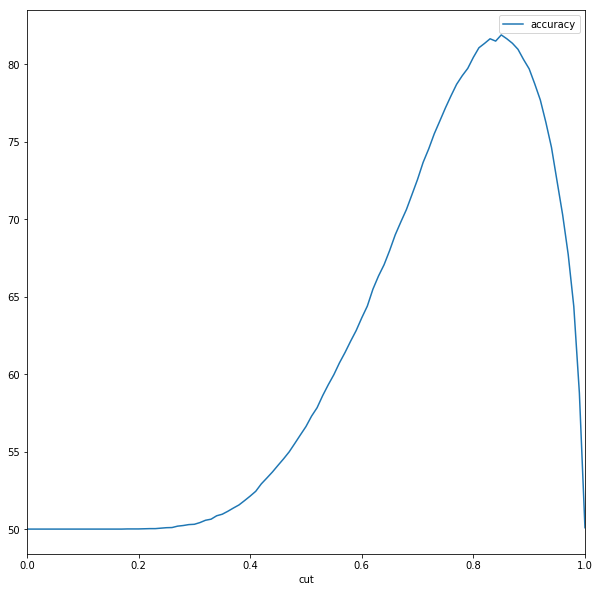

In [16]:
best_dev_cut, best_dev_accuracy = find_best_accuracy(dev_similarities, dev_labels)
print("[INFO] Best dev accuracy at cut {}: {}".format(best_dev_cut, best_dev_accuracy))

[INFO] Best test accuracy at cut 0.86: 81.72


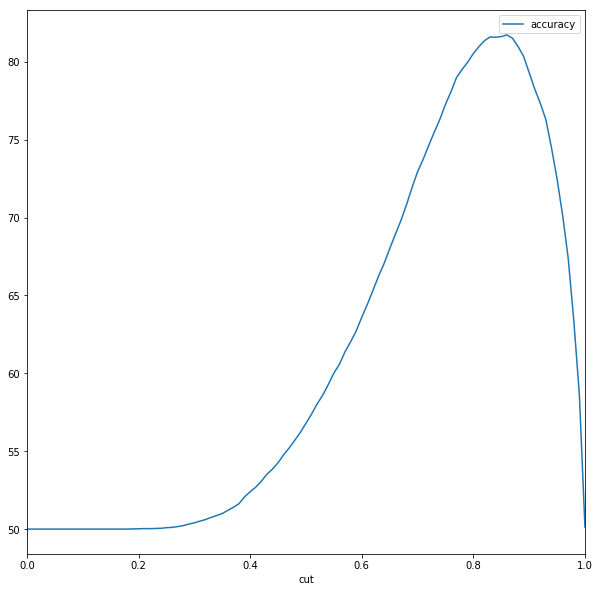

In [17]:
best_test_cut, best_test_accuracy = find_best_accuracy(test_similarities, test_labels)
print("[INFO] Best test accuracy at cut {}: {}".format(best_test_cut, best_test_accuracy))

In [18]:
print("[INFO] Test accuracy at best dev cut: {}".format(compute_accuracy(test_similarities, test_labels, best_dev_cut)))

[INFO] Test accuracy at best dev cut: 81.61


# Loss on triplets

Each training instance is composed by three item:

1. A first item that we call target (e.g., target question)
2. A second item which is related to the target item (e.g., question similar to the target question)
3. A third item which is NOT related to the target item (e.g., question unrelated to the target question)

Question: how do we create training instances?

* Use available positive pairs and related negative items if present
* Randomly sample a negative example (negative sampling)
* Select a negative example according to a score (most similar negative example, most difficult negative example for the current network)

## Siamese triplet loss ([Wang et al. 2014](https://arxiv.org/abs/1404.4661))

### $max\{0, M - (cos(E(q), E(q^{+}))\} - (cos(E(q), E(q^{-}))$

## Twin loss

### $max\{0, M_{1} - (cos(E(q), E(q^{+}))\} + max\{0, (cos(E(q), E(q^-)) - M_{2}\}$

# ATTENTION MECHANISMS

## Computing the attention

In this section we will apply the attention mechanism to compute a representation of second question which is conditioned on the first question, similar to the following paper: [Improved Representation Learning for Question Answer Matching](http://www.aclweb.org/anthology/P16-1044)

<img src="figures/attentive-network.png" alt="Attentive network" style="width: 500px;"/>

In this figure, the question and answer are encoded with a recurrent network which outputs a hidden state for each token (we use wide convolutions to obtain hidden states). Then, the question hidden states are pooled to obtain a single vector. The latter is used in the attention network to compute a scalar value for each answer hidden state. This value is then used to rescale the corresponding hidden state. In equations:

<img src="figures/attention.png" alt="Attentive network" style="width: 400px;"/>

In [19]:
class Attention(nn.Module):  
    def __init__(self,
                 context_dim,
                 hidden_dim,
                 attn_size):
        super(Attention, self).__init__()
        self.context_proj = nn.Linear(context_dim, attn_size, bias=True)
        self.hidden_proj = nn.Linear(hidden_dim, attn_size, bias=True)
        self.attn = nn.Linear(attn_size, 1, bias=True)
    
    def forward(self,
                context,  # batch x context_dim
                embedded_sequence,  # batch x sequence_length x hidden_dim
                mask=None,
               ):
        augmented_hidden_state = self.context_proj(context).unsqueeze(1) + self.hidden_proj(embedded_sequence)
        augmented_hidden_state = context.unsqueeze(1) + embedded_sequence
        attn_scores = F.tanh(self.attn(augmented_hidden_state))
        
        if mask is not None:
            attn_scores.data.masked_fill_(mask.byte().data, -9999.9)
            
        attn_scores = F.softmax(attn_scores)
        return embedded_sequence * attn_scores